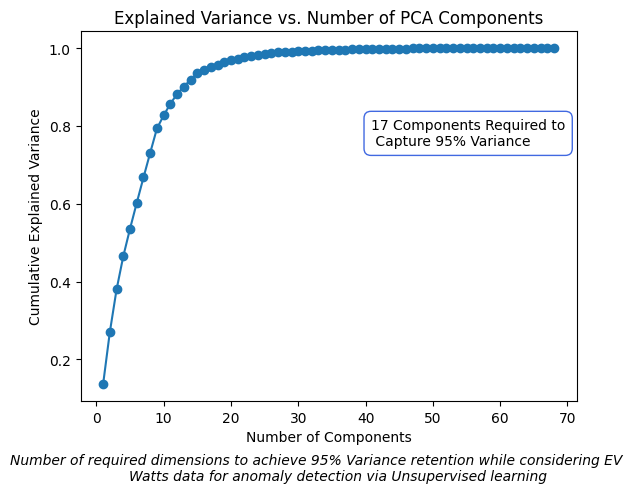

Beginning K-fold training and evaluation for Isolation Forest
Finished K-fold training and evaluation for Isolation Forest in 0.5min
Beginning K-fold training and evaluation for OC-SVM
Finished K-fold training and evaluation for OC-SVM in 2.0min
Beginning K-fold training and evaluation for LOF
Finished K-fold training and evaluation for LOF in 0.5min


,Model,Calinski-Harabasz,Davies-Bouldin,Silhouette
0,Isolation Forest,1.151148,60.693536,0.000002
1,LOF,0.753592,71.761748,0.000017
2,OC-SVM,0.650890,78.972916,-0.000870


In [70]:
#Import relavent packages
import time 
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import os 

#model options: 
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM #very slow
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import DBSCAN

#model eval packages
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score, silhouette_score
from sklearn.metrics import roc_curve

#Import pyscripts 
import Prep_data_UL_V2


def load_downsample(num_sample=5000): 
    """
    This function takes the number of sample points given, and down-samples the test and train dataset accordingly. 
    If the downsample amount is greater than the test dataset, then the downsample size is set to the length of the 
    dataset. 

    Inputs: n_sample
    Outputs: X_train, X_test, y_train, y_test 
    """
    
    dir_contents = os.listdir()
    file_list = ["UL_Xtrain.csv", "UL_Xtest.csv", "UL_ytrain.csv", "UL_ytest.csv"]
    for file in file_list:
        if file not in dir_contents:
            load_file = False
            break
        else: 
            load_file = True
    
    if load_file == True: 
        X_train = pd.read_csv(file_list[0])
        X_test = pd.read_csv(file_list[1])
        y_train = pd.read_csv(file_list[2])
        y_test = pd.read_csv(file_list[3])
        
    else: 
        X_train, X_test, y_train, y_test = Prep_data_UL_V2.main_execution(input_condition=1, test_ratio=0.2, anomaly_list=None)
    
    #Down-sampling
    if num_sample > len(y_test): num_sample = len(y_test) 
    X_train = X_train.sample(num_sample) 
    X_test = X_test.sample(num_sample) 
    y_train = y_train.sample(num_sample)
    y_test = y_test.sample(num_sample)

    return X_train, X_test, y_train, y_test


def evaluate_pca(input_df, variance_retention=0.95, view_plot=True): 
    """
    This function runs PCA analysis on the input dataframe of predictor variables to determine the min
    number of dimensions that should be retained by the dataset for our machine-learning tasks

    INPUTS: 
    input_df: a pandas dataframe of the predictor variables 
    variance_retention: a float value between 0 and 1 of the minimum variance captured by PCA
    view_plot: a boolean variable, that when true, plots the variance vs. the principle components quantity 

    OUTPTUS: 
    optimal_n_components: an integer variable declaring how many principle components should be used
    pca_X: the input_df transformed via PCA into the optimal dimension size 
    """

    #setup PCA 
    pca = PCA() 
    pca.fit(input_df) 

    #find the cumulative explained variance: 
    explained_variance = pca.explained_variance_ratio_
    cumulative_variance = explained_variance.cumsum()

    #get the optimal number of principle components: 
    optimal_n_components = (cumulative_variance >= 0.95).argmax() + 1

    #transform the data via PCA
    pca = PCA(n_components=optimal_n_components)
    pca_X = pca.fit_transform(input_df)

    X_plot = range(1, len(cumulative_variance) + 1)
    #plot the variance vs. PCA num. 
    if view_plot == True: 
        plt.plot(X_plot, cumulative_variance, marker='o')
        plt.xlabel('Number of Components')
        plt.ylabel('Cumulative Explained Variance')
        plt.title('Explained Variance vs. Number of PCA Components')
        plt.text(0.6*X_plot[-1], 0.75, f"{optimal_n_components} Components Required to\n Capture 95% Variance",
                 bbox=dict(facecolor='white', edgecolor='royalblue', boxstyle='round,pad=0.5'))
        plt.figtext(0.5, -0.05, """Number of required dimensions to achieve 95% Variance retention while considering EV  
        Watts data for anomaly detection via Unsupervised learning""", 
                wrap=True, horizontalalignment='center', fontsize=10, fontstyle='italic')
        plt.show()

    #Output desired vars 
    return(optimal_n_components, pca_X)


def apply_PCA(X_train, X_test, X, num_components): 
    """This function applies PCA to the training and test datasets for the n number of components
    INPUTS: 
    X_train, X_test, X: pandas datasets related to predictor variables
    n_components: the number of components to reduce to dataframes to

    OUTPUTS: 
    PCA_X_train, PCA_X_test, PCA_X: the X datasets transformed by PCA.
    """

    #setup PCA     
    pca = PCA(n_components=num_components)
    pca_X_train = pca.fit_transform(X_train)
    pca_X_test = pca.transform(X_test)
    pca_X = pca.fit_transform(X)
    
    return pca_X_train, pca_X_test, pca_X


def evaluate_ISF(X_train, X_test, y_train, y_test, n_samples=100000, n_estimate=100): 
    """
    This function builds an isolation forest model, based on the specified 
    training data, anomaly data, and number of samples. 

    INPUTS: 
    X_train: the training dataset using only non-anomalous data 
    X_anomalies: the anomaly dataset 
    n_samples: the number of samples to consider 
    n_estimate: the number of estimators used in the model (default to 100)

    OUTPUTS: 
    precision: the precision of the isolation forest model 
    recall: the recall of the isolation forest model 
    accuracy: the accuracy of the isolation forest model 
    """
    
    #Setup the model: 
    ISF = IsolationForest(n_estimators=n_estimate,
                          max_samples=n_samples,
                          n_jobs=-1,
                          random_state=42
                          )

    #Fit to the non-anomalous data
    ISF.fit(X_train)

    #Score performance               
    pred_train = ISF.predict(X_train)
    pred_test = ISF.predict(X_test)

    precision, recall, F1 = get_scores(pred_train, y_train)
    precision, recall, F1 = get_scores(pred_test, y_test)
    
    return precision, recall, F1 


def evaluate_OCSVM(X_train,X_test, y_train, y_test): #too slow o^2
    start = time.time()
    ocsvm = OneClassSVM()
    ocsvm = ocsvm.fit(X_train)
    pred_train = ocsvm.predict(X_train)
    pred_test = ocsvm.predict(X_test)

    #get performance: 
    precision, recall, F1 = get_scores(pred_train, y_train)
    precision, recall, F1 = get_scores(pred_test, y_test)

    end = time.time() 
    duration = np.round((end-start)/60,1)
    print("Total completion time, 1 iter: {duration}min")
    return precision, recall, F1 


def evaluate_LOF(X_train, X_test, y_train, y_test):
    start = time.time()
    
    # Initialize and fit Local Outlier Factor model
    lof = LocalOutlierFactor(novelty=True)
    lof.fit(X_train)
    
    # Predict on the training set and anomalies
    pred_train = lof.predict(X_train)
    pred_test = lof.predict(X_test)

    # Get performance
    precision, recall, F1 = get_scores(pred_train, y_train)
    precision, recall, F1 = get_scores(pred_test, y_test)
    
    end = time.time()
    duration = np.round((end - start) / 60, 1)
    print(f"Total completion time, 1 iter: {duration} min")
    
    return precision, recall, F1 


def get_scores(input_prediction, input_data): 
    TP = np.sum((input_prediction == 1) & (input_data == 1))
    TN = np.sum((input_prediction == 0) & (input_data == 0))
    FP = np.sum((input_prediction == 1) & (input_data == 0))
    FN = np.sum((input_prediction == 0) & (input_data == 1))   

    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    F1 = 2 * precision * recall / (precision + recall)  
    
    return precision, recall, F1


def get_data_pipe(num_sample=5000): 
    """This function serves as the data retrieval pipeline for unsupervised learning. It retrieves the scaled, transformed 
    datasets, then identifies optimal principal components for 95% variance retention, and finally transforms the data to
    be represented by the dimensional feature space of the principal components. 
    
    INPUTS: 
    num_sample, an interger which specifies how many records to pull from the original dataset for modeling purposes
    
    OUTPUTS: 
    PCA_X_train, PCA_X_test, y_train, y_test, PCA_X, y. Each are pandas dataframes. X's referring to predictor features, y's 
    to the target feature dataframe.
    """
    
    X_train, X_test, y_train, y_test = load_downsample(num_sample)
    X_train, X_test = X_train.reset_index(drop=True), X_test.reset_index(drop=True)
    y_train, y_test = y_train.reset_index(drop=True), y_test.reset_index(drop=True)
    
    X = pd.concat([X_train, X_test], axis=0).reset_index(drop=True)
    y = pd.concat([y_train, y_test], axis=0).reset_index(drop=True)

    #Find the optimal number of components for dimension reduction
    optimal_n_components, pca_X = evaluate_pca(X_train, variance_retention=0.95, view_plot=True)

    #Apply PCA to the 
    pca_X_train, pca_X_test, pca_X = apply_PCA(X_train, X_test, X, optimal_n_components)
    
    return(pca_X_train, pca_X_test, y_train, y_test, pca_X, y)


def evaluate_model_cluster(input_model, input_X_train, input_y_train, all_scores=True):
    
    """This function trains an input model, and then scores its performance for detecting anomalies
    INPUTS: 
    input_model: the sklearn model to train and score
    input_X_train: the training dataset (no anomalies) 
    input_X_anomalies: the dataset for anomaly detection  

    OUTPUTS: 
    precision, recall, accuracy, F1_score: float values representing the model performance
    """
    
    
    #Fit the model
    input_model.fit(input_X_train)
    
    #Score performance               
    ch_score = calinski_harabasz_score(input_X_train, input_y_train)
    if all_scores == True: 
        db_score = davies_bouldin_score(input_X_train, input_y_train)
        sil_score = silhouette_score(input_X_train, input_y_train)
    else: 
        db_score = None
        sil_score = None
        
    return ch_score, db_score, sil_score


def review_models_pipe(input_X, input_y, all_scores=True): 
    """
    Function to assess via K-fold each of the diff. model types: 
    """

    
    #Let's setup the pipeline for evaluation 
    
    #list of models & their names  
    models = [IsolationForest(),OneClassSVM(),LocalOutlierFactor(novelty=True)] 
    names = ["Isolation Forest", "OC-SVM", "LOF"] 
    
    #Setup empty list for model results 
    model_list = []
    score_ch_train_list = []
    score_db_train_list = []
    score_si_list = []
    
    #setup cross val: 
    n_splits = 5
    train_size = 0.8 
    
    for name, model in zip(names, models): 
        print(f'Beginning K-fold training and evaluation for {name}')    
        start = time.time()
        temp_score_ch_train_list = []
        temp_score_db_train_list = [] 
        temp_score_si_list = [] 
        

        for i in range(n_splits):
            sample_indices = np.random.choice(len(input_X), size=int(len(input_X)/n_splits), replace=False)
            
            temp_X_train = input_X[sample_indices]
            temp_y_train = input_y[sample_indices]
            
            temp_score_ch_train, temp_score_db_train, temp_score_si = evaluate_model_cluster(model, temp_X_train, temp_y_train, all_scores)
            temp_score_ch_train_list.append(temp_score_ch_train)
            temp_score_db_train_list.append(temp_score_db_train)
            temp_score_si_list.append(temp_score_si)

    
        score_ch_train_list.append(np.mean(temp_score_ch_train_list))
        score_db_train_list.append(np.mean(temp_score_db_train_list))
        score_si_list.append(np.mean(temp_score_si_list))
        
        model_list.append(name)
    
        stop = time.time()
        duration = np.round((stop - start) / 60,1) 
        print(f'Finished K-fold training and evaluation for {name} in {duration}min')     
    
    evaluation_df = pd.DataFrame({"Model": model_list, "Calinski-Harabasz": score_ch_train_list, "Davies-Bouldin": score_db_train_list, 
                                  "Silhouette": score_si_list}) 

    evaluation_df = evaluation_df.sort_values(by="Calinski-Harabasz", ascending=False).reset_index(drop=True)
    evaluation_df = evaluation_df.dropna(axis=1)
    
    return evaluation_df


if __name__ == "__main__": 
    pca_X_train, pca_X_test, y_train, y_test, pca_X, y = get_data_pipe(num_sample=40000)
    test = review_models3(pca_X, np.ravel(y))
    test

### Load Data